# Normalization with LightGBM

In [1]:
import numpy as np
import pandas as pd

# 0. Introduction of Data

In [2]:
products = pd.read_csv("../data/products.csv")
aisles = pd.read_csv("../data/aisles.csv")
departments = pd.read_csv("../data/departments.csv")
orders = pd.read_csv("../data/orders.csv")
prior = pd.read_csv("../data/order_products__prior.csv")
train = pd.read_csv("../data/order_products__train.csv")
frame_train = pd.read_csv("../data/frame_train.csv")
frame_test = pd.read_csv("../data/frame_test.csv")
userXproduct = pd.read_csv("../data/userXproduct.csv")

### orders.csv

In [3]:
print("Size of orders : ", len(orders))
orders.head()

Size of orders :  3421083


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


### order_products_prior.csv

In [4]:
print("Size of prior : ", len(prior))
prior.head()

Size of prior :  32434489


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### products.csv

In [5]:
print("Size of Products : ", len(products))
products.head()

Size of Products :  49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### frame_train.csv

In [6]:
print("Size of frame of train : ", len(frame_train))
frame_train.head()

Size of frame of train :  8474661


,user_id,order_id,product_id,products
0,1,1187899,17122,0
1,1,1187899,196,1
2,1,1187899,26405,1
3,1,1187899,46149,1
4,1,1187899,14084,0


# 1. orders Information - categorization of order hour

In [7]:
orders.set_index('order_id', inplace=True, drop=False)

In [8]:
orders['categorized_order_hour_of_day'] = 0
orders.loc[orders['order_hour_of_day']>=9,'categorized_order_hour_of_day'] = 1
orders.loc[orders['order_hour_of_day']>=13,'categorized_order_hour_of_day'] = 2
orders.loc[orders['order_hour_of_day']>=19,'categorized_order_hour_of_day'] = 3
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,categorized_order_hour_of_day
order_id,,,,,,,,
2539329,2539329,1,prior,1,2,8,NaN,0
2398795,2398795,1,prior,2,3,7,15.0,0
473747,473747,1,prior,3,3,12,21.0,1
2254736,2254736,1,prior,4,4,7,29.0,0
431534,431534,1,prior,5,4,15,28.0,2


In [9]:
orders = orders.join(pd.get_dummies(orders['categorized_order_hour_of_day'], prefix='categorized_hour'))
orders.drop(['categorized_order_hour_of_day'], axis=1, inplace=True)

In [10]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,categorized_hour_0,categorized_hour_1,categorized_hour_2,categorized_hour_3
order_id,,,,,,,,,,,
2539329,2539329,1,prior,1,2,8,NaN,1,0,0,0
2398795,2398795,1,prior,2,3,7,15.0,1,0,0,0
473747,473747,1,prior,3,3,12,21.0,0,1,0,0
2254736,2254736,1,prior,4,4,7,29.0,1,0,0,0
431534,431534,1,prior,5,4,15,28.0,0,0,1,0


# 2. Integrate Products Information
* products와 prior에서 얻을 수 있는 제품 관련 정보를 통합
* 기존의 attribute인 product_id, product_name, aisle_id, department_id
* 여기에 prior에서 얻을 수 있는 해당 제품에 판매에 관련된 attribute를 추가
* 총주문량(total_orders), 총재주문량(total_reorders), 재주문율(reorder_rate)을 추가함

In [11]:
productsXprior = pd.DataFrame()
productsXprior['product_id'] = prior.groupby(prior.product_id).size().index
productsXprior['product_orders'] = prior.groupby(prior.product_id).size().values
productsXprior['product_reorders'] = prior['reordered'].groupby(prior.product_id).sum().values
productsXprior['product_reorder_rate'] = (productsXprior.product_reorders / productsXprior.product_orders)
print("Size of productsXprior : ", len(productsXprior))
productsXprior.head()

Size of productsXprior :  49677


,product_id,product_orders,product_reorders,product_reorder_rate
0,1,1852,1136,0.613391
1,2,90,12,0.133333
2,3,277,203,0.732852
3,4,329,147,0.446809
4,5,15,9,0.600000


In [12]:
Products = products.merge(productsXprior, on='product_id', how='outer')
print("Size of Products : ", len(Products))
Products.head()

Size of Products :  49688


,product_id,product_name,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate
0,1,Chocolate Sandwich Cookies,61,19,1852.0,1136.0,0.613391
1,2,All-Seasons Salt,104,13,90.0,12.0,0.133333
2,3,Robust Golden Unsweetened Oolong Tea,94,7,277.0,203.0,0.732852
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329.0,147.0,0.446809
4,5,Green Chile Anytime Sauce,5,13,15.0,9.0,0.600000


In [13]:
Products[Products.isnull().any(axis=1)]

,product_id,product_name,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate
3629,3630,Protein Granola Apple Crisp,57,14,NaN,NaN,NaN
3717,3718,Wasabi Cheddar Spreadable Cheese,21,16,NaN,NaN,NaN
7044,7045,Unpeeled Apricot Halves in Heavy Syrup,88,13,NaN,NaN,NaN
25382,25383,Chocolate Go Bites,61,19,NaN,NaN,NaN
27498,27499,Non-Dairy Coconut Seven Layer Bar,100,21,NaN,NaN,NaN
36232,36233,Water With Electrolytes,100,21,NaN,NaN,NaN
37702,37703,Ultra Sun Blossom Liquid 90 loads Fabric Enhan...,75,17,NaN,NaN,NaN
43724,43725,Sweetart Jelly Beans,100,21,NaN,NaN,NaN
45970,45971,12 Inch Taper Candle White,101,17,NaN,NaN,NaN
46624,46625,Single Barrel Kentucky Straight Bourbon Whiskey,31,7,NaN,NaN,NaN


In [14]:
Products = Products.replace(np.NaN, 0)
print("Size of Products : ", len(Products))
Products.head()

Size of Products :  49688


,product_id,product_name,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate
0,1,Chocolate Sandwich Cookies,61,19,1852.0,1136.0,0.613391
1,2,All-Seasons Salt,104,13,90.0,12.0,0.133333
2,3,Robust Golden Unsweetened Oolong Tea,94,7,277.0,203.0,0.732852
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329.0,147.0,0.446809
4,5,Green Chile Anytime Sauce,5,13,15.0,9.0,0.600000


# 3. Integrate_Users_Information
* prior와 orders를 통합(priorXorders)하여 user_id, order_id, product_id를 하나로 모음.
* priorXorders를 기반으로 하여 유저 정보를 담고 있는 Users를 생성.

In [16]:
priorXorders = prior.merge(orders, on='order_id')
print("Size of Prior : ", len(priorXorders))
priorXorders.head()

Size of Prior :  32434489


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,categorized_hour_0,categorized_hour_1,categorized_hour_2,categorized_hour_3
0,2,33120,1,1,202279,prior,3,5,9,8.0,0,1,0,0
1,2,28985,2,1,202279,prior,3,5,9,8.0,0,1,0,0
2,2,9327,3,0,202279,prior,3,5,9,8.0,0,1,0,0
3,2,45918,4,1,202279,prior,3,5,9,8.0,0,1,0,0
4,2,30035,5,0,202279,prior,3,5,9,8.0,0,1,0,0


In [17]:
user_orders = pd.DataFrame()
user_orders['user_avg_orders_period'] = orders.groupby('user_id')['days_since_prior_order'].mean()
user_orders['user_total_orders'] = orders.groupby('user_id').size()

user_orders['user_id'] = user_orders.index
user_orders.index.name = None

print("Size of user_orders : ", len(user_orders))
user_orders.head()

Size of user_orders :  206209


,user_avg_orders_period,user_total_orders,user_id
1,19.000000,11,1
2,16.285714,15,2
3,12.000000,13,3
4,17.000000,6,4
5,11.500000,5,5


In [18]:
user_prior = pd.DataFrame()
user_prior['user_total_products'] = priorXorders.groupby('user_id').size()
user_prior['ordered_products_set'] = priorXorders.groupby('user_id')['product_id'].apply(set)
user_prior['user_unique_products'] = (user_prior.ordered_products_set.map(len))
user_prior = user_prior[['user_total_products', 'user_unique_products', 'ordered_products_set']]

user_prior['user_id'] = user_prior.index
user_prior.index.name = None

print("Size of user_prior : ", len(user_prior))
user_prior.head()

Size of user_prior :  206209


,user_total_products,user_unique_products,ordered_products_set,user_id
1,59,18,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",1
2,195,102,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",2
3,88,33,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",3
4,18,17,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",4
5,37,23,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",5


In [19]:
Users = user_prior.merge(user_orders, on='user_id')
print("Size of users : ", len(Users))
Users.head()

Size of users :  206209


,user_total_products,user_unique_products,ordered_products_set,user_id,user_avg_orders_period,user_total_orders
0,59,18,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",1,19.000000,11
1,195,102,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",2,16.285714,15
2,88,33,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",3,12.000000,13
3,18,17,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",4,17.000000,6
4,37,23,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",5,11.500000,5


In [20]:
Users['user_avg_cart'] = (Users.user_total_products / (Users.user_total_orders - 1))
print("Size of users : ", len(Users))
Users.head()

Size of users :  206209


,user_total_products,user_unique_products,ordered_products_set,user_id,user_avg_orders_period,user_total_orders,user_avg_cart
0,59,18,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",1,19.000000,11,5.900000
1,195,102,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",2,16.285714,15,13.928571
2,88,33,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",3,12.000000,13,7.333333
3,18,17,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",4,17.000000,6,3.600000
4,37,23,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",5,11.500000,5,9.250000


# normalization Users['user_unique_products']

In [21]:
Users['user_total_products'] =(Users['user_total_products']-Users['user_total_products'].mean())/(Users['user_total_products'].std())
Users['user_unique_products'] =(Users['user_unique_products']-Users['user_unique_products'].mean())/(Users['user_unique_products'].std())


Users.head()

,user_total_products,user_unique_products,ordered_products_set,user_id,user_avg_orders_period,user_total_orders,user_avg_cart
0,0.015046,0.023448,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",1,19.000000,11,5.900000
1,0.051585,0.139310,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",2,16.285714,15,13.928571
2,0.022837,0.044138,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",3,12.000000,13,7.333333
3,0.004030,0.022069,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",4,17.000000,6,3.600000
4,0.009135,0.030345,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",5,11.500000,5,9.250000


# 4. UP(userXproduct) Information

In [22]:
userXproduct.columns = ['user_product','UP_orders','UP_last_order_id','UP_sum_pos_in_cart']
print('Size of user X product', len(userXproduct))
userXproduct.head()

Size of user X product 13307953


,user_product,UP_orders,UP_last_order_id,UP_sum_pos_in_cart
0,14126415872,5,843810,63
1,20535312385,1,2699553,9
2,1375731717,7,2844957,51
3,8959033352,4,1924807,57
4,7342828204,3,723315,13


# 5. Train Data Generation
* ### 미리 만들어 둔 frame_train을 기반으로 위의 orders, Products, Users 정보를 통합시켜 train data를 만듬.
* order_prior, order_train은 학습데이터로 포함 X, order_test가 없기 때문에 test데이터에 해당 attribute를 포함시킬 수 없음.

In [23]:
train_df = frame_train.copy()
train_df.set_index(['user_id','order_id','product_id']).head(10)

products
user_id order_id product_id          
1       1187899  17122              0
                 196                1
                 26405              1
                 46149              1
                 14084              0
                 13032              1
                 26088              1
                 39657              1
                 12427              0
                 25133              1

### 1) orders Information 통합

In [24]:
train_df = train_df.merge(orders, how='left', on=['user_id','order_id'])
train_df.head()

,user_id,order_id,product_id,products,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,categorized_hour_0,categorized_hour_1,categorized_hour_2,categorized_hour_3
0,1,1187899,17122,0,train,11,4,8,14.0,1,0,0,0
1,1,1187899,196,1,train,11,4,8,14.0,1,0,0,0
2,1,1187899,26405,1,train,11,4,8,14.0,1,0,0,0
3,1,1187899,46149,1,train,11,4,8,14.0,1,0,0,0
4,1,1187899,14084,0,train,11,4,8,14.0,1,0,0,0


### 2) Products Information 통합

In [25]:
train_df = train_df.merge(Products, how='left', on='product_id')
train_df.head()

,user_id,order_id,product_id,products,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,categorized_hour_0,categorized_hour_1,categorized_hour_2,categorized_hour_3,product_name,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,norm_product_reorders
0,1,1187899,17122,0,train,11,4,8,14.0,1,0,0,0,Honeycrisp Apples,24,4,13880.0,9377.0,0.675576,0.023524
1,1,1187899,196,1,train,11,4,8,14.0,1,0,0,0,Soda,77,7,35791.0,27791.0,0.776480,0.069720
2,1,1187899,26405,1,train,11,4,8,14.0,1,0,0,0,XL Pick-A-Size Paper Towel Rolls,54,17,1214.0,536.0,0.441516,0.001345
3,1,1187899,46149,1,train,11,4,8,14.0,1,0,0,0,Zero Calorie Cola,77,7,8558.0,6953.0,0.812456,0.017443
4,1,1187899,14084,0,train,11,4,8,14.0,1,0,0,0,Organic Unsweetened Vanilla Almond Milk,91,16,15935.0,12923.0,0.810982,0.032420


### 3) Users Information 통합

In [26]:
train_df = train_df.merge(Users, how='left', on='user_id')
train_df.head()

,user_id,order_id,product_id,products,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,categorized_hour_0,...,product_orders,product_reorders,product_reorder_rate,norm_product_reorders,user_total_products,user_unique_products,ordered_products_set,user_avg_orders_period,user_total_orders,user_avg_cart
0,1,1187899,17122,0,train,11,4,8,14.0,1,...,13880.0,9377.0,0.675576,0.023524,0.015046,0.023448,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",19.0,11,5.9
1,1,1187899,196,1,train,11,4,8,14.0,1,...,35791.0,27791.0,0.776480,0.069720,0.015046,0.023448,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",19.0,11,5.9
2,1,1187899,26405,1,train,11,4,8,14.0,1,...,1214.0,536.0,0.441516,0.001345,0.015046,0.023448,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",19.0,11,5.9
3,1,1187899,46149,1,train,11,4,8,14.0,1,...,8558.0,6953.0,0.812456,0.017443,0.015046,0.023448,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",19.0,11,5.9
4,1,1187899,14084,0,train,11,4,8,14.0,1,...,15935.0,12923.0,0.810982,0.032420,0.015046,0.023448,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",19.0,11,5.9


### Extra Feature) days_since_ratio 추가

In [27]:
train_df['days_since_ratio'] = train_df.days_since_prior_order / train_df.user_avg_orders_period

### 4) UP(userXproduct) Information 추가

In [28]:
train_df['user_product'] = train_df.user_id * 100000 + train_df.product_id
train_df = train_df.merge(userXproduct, how='left', on='user_product')
train_df.drop(['user_product'], axis=1, inplace=True)

In [29]:
train_df['UP_orders_ratio'] = train_df.UP_orders / train_df.user_total_orders
train_df['UP_avg_pos_in_cart'] = train_df.UP_sum_pos_in_cart / train_df.UP_orders
train_df['UP_reorder_rate'] = train_df.UP_orders / train_df.user_total_orders
train_df['UP_orders_since_last'] = train_df.user_total_orders - train_df.UP_last_order_id.map(orders.order_number)
train_df['UP_delta_hour_vs_last'] = abs(train_df.order_hour_of_day - train_df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x))

train_df.head()

,user_id,order_id,product_id,products,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,categorized_hour_0,...,user_avg_cart,days_since_ratio,UP_orders,UP_last_order_id,UP_sum_pos_in_cart,UP_orders_ratio,UP_avg_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last
0,1,1187899,17122,0,train,11,4,8,14.0,1,...,5.9,0.736842,1,431534,6,0.090909,6.0,0.090909,6,7
1,1,1187899,196,1,train,11,4,8,14.0,1,...,5.9,0.736842,10,2550362,14,0.909091,1.4,0.909091,1,0
2,1,1187899,26405,1,train,11,4,8,14.0,1,...,5.9,0.736842,2,2254736,10,0.181818,5.0,0.181818,7,1
3,1,1187899,46149,1,train,11,4,8,14.0,1,...,5.9,0.736842,3,2550362,9,0.272727,3.0,0.272727,1,0
4,1,1187899,14084,0,train,11,4,8,14.0,1,...,5.9,0.736842,1,2539329,2,0.090909,2.0,0.090909,10,0


# normalization train_df['UP_orders_since_last']

In [60]:
train_mean = train_df['UP_orders_since_last'].mean()
train_std = train_df['UP_orders_since_last'].std()
train_df['UP_orders_since_last'] =(train_df['UP_orders_since_last']-train_df['UP_orders_since_last'].mean())/(train_df['UP_orders_since_last'].std())

train_df[['UP_orders_since_last','user_unique_products','user_total_products']]

,UP_orders_since_last,user_unique_products,user_total_products
0,0.051020,0.023448,0.015046
1,0.000000,0.023448,0.015046
2,0.061224,0.023448,0.015046
3,0.000000,0.023448,0.015046
4,0.091837,0.023448,0.015046
5,0.000000,0.023448,0.015046
6,0.081633,0.023448,0.015046
7,0.000000,0.023448,0.015046
8,0.000000,0.023448,0.015046
9,0.000000,0.023448,0.015046


### 모든 데이터 통합 완료 & 사용할 attribute 선정

In [31]:
train_df.columns

Index(['user_id', 'order_id', 'product_id', 'products', 'eval_set',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'categorized_hour_0', 'categorized_hour_1',
       'categorized_hour_2', 'categorized_hour_3', 'product_name', 'aisle_id',
       'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'norm_product_reorders', 'user_total_products',
       'user_unique_products', 'ordered_products_set',
       'user_avg_orders_period', 'user_total_orders', 'user_avg_cart',
       'days_since_ratio', 'UP_orders', 'UP_last_order_id',
       'UP_sum_pos_in_cart', 'UP_orders_ratio', 'UP_avg_pos_in_cart',
       'UP_reorder_rate', 'UP_orders_since_last', 'UP_delta_hour_vs_last'],
      dtype='object')

In [32]:
features = [
    # order information
    'categorized_hour_0', 'categorized_hour_1', 'categorized_hour_2', 'categorized_hour_3',
    'days_since_prior_order', 'days_since_ratio',
    # product information
    'aisle_id', 'department_id', 'product_orders', 'product_reorders', 'product_reorder_rate', 
    # user information
    'user_total_products', 'user_unique_products', 'user_avg_orders_period', 'user_total_orders', 'user_avg_cart', 
    # userXproduct information
    'UP_orders', 'UP_orders_ratio', 'UP_avg_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last', 'UP_delta_hour_vs_last'
]

In [33]:
train_X = train_df[features]
train_y = train_df['products']

# 6. Test Data Generation

In [34]:
test_df = frame_test.copy()
test_df = test_df.merge(orders, how='left', on=['user_id','order_id'])
test_df = test_df.merge(Products, how='left', on='product_id')
test_df = test_df.merge(Users, how='left', on='user_id')

test_df['days_since_ratio'] = test_df.days_since_prior_order / test_df.user_avg_orders_period

test_df['user_product'] = test_df.user_id * 100000 + test_df.product_id
test_df = test_df.merge(userXproduct, how='left', on='user_product')
test_df.drop(['user_product'], axis=1, inplace=True)

test_df['UP_orders_ratio'] = test_df.UP_orders / test_df.user_total_orders
test_df['UP_avg_pos_in_cart'] = test_df.UP_sum_pos_in_cart / test_df.UP_orders
test_df['UP_reorder_rate'] = test_df.UP_orders / test_df.user_total_orders
test_df['UP_orders_since_last'] = test_df.user_total_orders - test_df.UP_last_order_id.map(orders.order_number)
test_df['UP_delta_hour_vs_last'] = abs(test_df.order_hour_of_day - test_df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x))


# normalization test_df['UP_orders_since_last']

In [35]:
test_df['UP_orders_since_last'] =(test_df['UP_orders_since_last']-train_mean)/(train_std)

test_df['UP_orders_since_last']

0          0.010204
1          0.061224
2          0.030612
3          0.000000
4          0.051020
5          0.102041
6          0.020408
7          0.040816
8          0.091837
9          0.000000
10         0.000000
11         0.071429
12         0.051020
13         0.102041
14         0.030612
15         0.000000
16         0.112245
17         0.051020
18         0.081633
19         0.010204
20         0.040816
21         0.071429
22         0.102041
23         0.071429
24         0.051020
25         0.091837
26         0.102041
27         0.071429
28         0.000000
29         0.000000
             ...   
4833262    0.061224
4833263    0.091837
4833264    0.000000
4833265    0.030612
4833266    0.000000
4833267    0.020408
4833268    0.040816
4833269    0.102041
4833270    0.051020
4833271    0.000000
4833272    0.000000
4833273    0.142857
4833274    0.183673
4833275    0.204082
4833276    0.387755
4833277    0.306122
4833278    0.377551
4833279    0.397959
4833280    0.112245


In [36]:
test_X = test_df[features]

# 7. Learning & Prediction

In [37]:
import lightgbm as lgb

In [38]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 100

### Learning

In [39]:
train_X_ds = lgb.Dataset(train_X, label=train_y, categorical_feature=['aisle_id','department_id'])

In [40]:
bst = lgb.train(params, train_X_ds, ROUNDS)

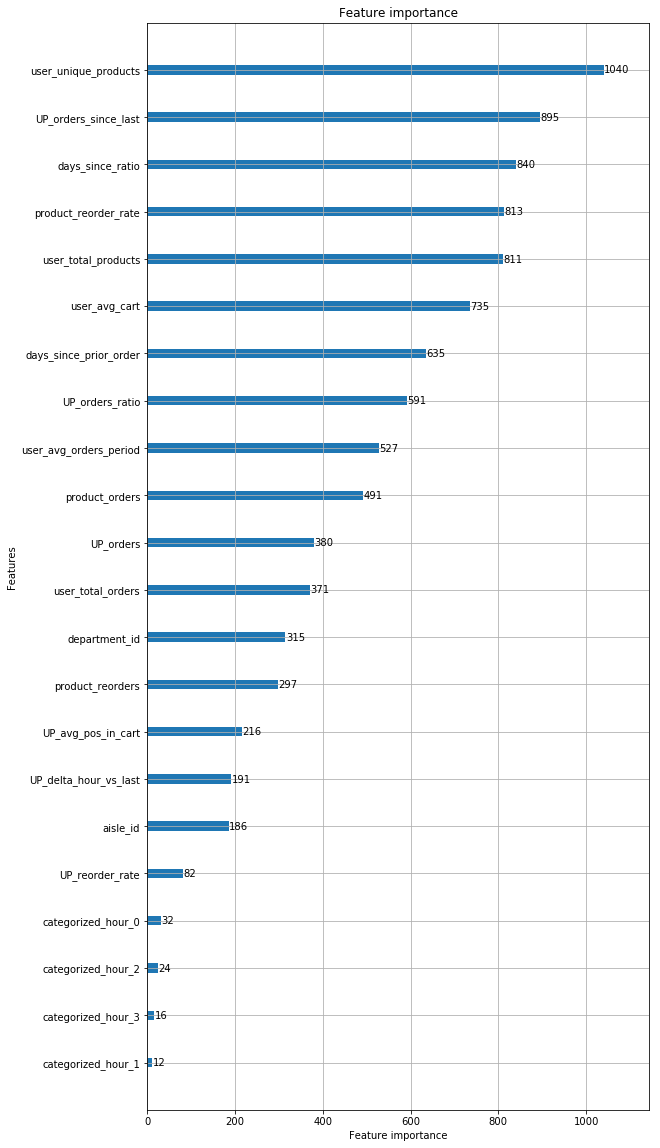

In [41]:
%matplotlib inline 
lgb.plot_importance(bst, figsize=(9,20))

### Prediction

In [42]:
result = bst.predict(test_X)

In [43]:
result = pd.concat([frame_test,pd.DataFrame(result, columns=['predict'])], axis=1)

In [44]:
result.head()

,user_id,order_id,product_id,predict
0,3,2774568,17668,0.364363
1,3,2774568,44683,0.070070
2,3,2774568,48523,0.083777
3,3,2774568,21903,0.636941
4,3,2774568,14992,0.084690


In [45]:
result

,user_id,order_id,product_id,predict
0,3,2774568,17668,0.364363
1,3,2774568,44683,0.070070
2,3,2774568,48523,0.083777
3,3,2774568,21903,0.636941
4,3,2774568,14992,0.084690
5,3,2774568,21137,0.065396
6,3,2774568,32402,0.192033
7,3,2774568,22035,0.153873
8,3,2774568,49683,0.044500
9,3,2774568,39190,0.752548


# 8. Prediction Probability 기반 최종 products list 생성

In [46]:
sorted_result = result.sort_values(['user_id', 'predict'], ascending=[True,False])

In [47]:
sorted_result.head()

,user_id,order_id,product_id,predict
9,3,2774568,39190,0.752548
10,3,2774568,47766,0.706004
3,3,2774568,21903,0.636941
28,3,2774568,23650,0.397347
0,3,2774568,17668,0.364363


In [48]:
sorted_result.reset_index(inplace=True)
sorted_result.drop(['index'], axis=1, inplace=True)
sorted_result.head()

,user_id,order_id,product_id,predict
0,3,2774568,39190,0.752548
1,3,2774568,47766,0.706004
2,3,2774568,21903,0.636941
3,3,2774568,23650,0.397347
4,3,2774568,17668,0.364363


In [49]:
sorted_result

,user_id,order_id,product_id,predict
0,3,2774568,39190,0.752548
1,3,2774568,47766,0.706004
2,3,2774568,21903,0.636941
3,3,2774568,23650,0.397347
4,3,2774568,17668,0.364363
5,3,2774568,18599,0.324695
6,3,2774568,43961,0.314142
7,3,2774568,24810,0.282039
8,3,2774568,32402,0.192033
9,3,2774568,16797,0.164554


In [50]:
ordered_products = sorted_result.groupby(['user_id', 'order_id'])['product_id'].apply(list)
ordered_products

user_id  order_id
3        2774568     [39190, 47766, 21903, 23650, 17668, 18599, 439...
4        329954      [26576, 21573, 25623, 35469, 25146, 19057, 376...
6        1528013     [21903, 38293, 8424, 27521, 45007, 25659, 4867...
11       1376945     [8309, 27959, 14947, 13176, 33572, 28465, 3465...
12       1356845     [13176, 7076, 10863, 14992, 11520, 28134, 2161...
15       2161313     [10441, 196, 12427, 14715, 27839, 11266, 37710...
16       1416320     [24852, 21903, 21137, 5134, 17948, 41950, 2456...
19       1735923     [17008, 34690, 31487, 35123, 15131, 196, 12108...
20       1980631       [13575, 22362, 9387, 46061, 13914, 6184, 41400]
22       139655      [27845, 17794, 22935, 35221, 13176, 22963, 249...
25       1411408     [22008, 26452, 43758, 10096, 37119, 27521, 121...
26       2940603     [19894, 44632, 30592, 31615, 14947, 10339, 185...
28       1192143     [24852, 47626, 35510, 27307, 49683, 8424, 4195...
31       280888      [32566, 19213, 41406, 12440, 13966, 35

In [51]:
d = dict()
for (uid, oid), row in ordered_products.iteritems():
    avg_cart = Users[Users.user_id == uid]['user_avg_cart'].values[0]
    
    row = row[:int(round(avg_cart))]
    
    for prod in row:    
        try:
            d[oid] += ' ' + str(prod)
        except:
            d[oid] = str(prod)

In [52]:
output = pd.DataFrame.from_dict(d, orient='index')
output.reset_index(inplace=True)
output.columns = ['order_id', 'products']
output.head()

,order_id,products
0,2774568,39190 47766 21903 23650 17668 18599 43961
1,329954,26576 21573 25623 35469
2,1528013,21903 38293 8424 27521 45007
3,1376945,8309 27959 14947 13176 33572 28465 34658 44632...
4,1356845,13176 7076 10863 14992 11520 28134 21616 22959...


In [53]:
output.to_csv('LightGBM-improving_userXproduct.csv', index=False)